Helper functions to convert the problem into the appropriate Hamiltonian form.


In [ ]:
from pyqubo import Spin, Binary, Array
import math
import numpy as np


def basis_to_gram_matrix(basis):
    if not isinstance(basis, np.ndarray):
        raise ValueError("Basis must be a numpy array")
    
    return basis @ basis.T


def gram_to_quadratic_form(gram_matrix):
    x, y = gram_matrix.shape
    if x != y:
        raise ValueError("Gram matrix must be square")
    
    # Diagonal terms
    diag = {}
    for i in range(x):
        diag[i] = gram_matrix[i, i]
    
    # Off-diagonal terms
    off_diag = {}
    for i in range(x):
        for j in range(i + 1, y):
            off_diag[(i, j)] = gram_matrix[i, j] + gram_matrix[j, i]
    
    return diag, off_diag


def substitution_array(variable_name, num_variables, bounds):
    # Handle bounds input
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        num_bits = math.floor(math.log2(2 * bound)) + 1
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits, vartype='BINARY')
        
        # Coefficients for the encoding
        coeffs = [2**j for j in range(num_bits - 1)]
        last_coeff = 2 * bound + 1 - 2**math.floor(math.log2(2 * bound))
        coeffs.append(last_coeff)
        
        # Build the substitution expression
        sub = -bound
        for j, coeff in enumerate(coeffs):
            sub += coeff * binary_vars[j]
        
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def substitution_array_for_nonzero(variable_name, num_variables, bounds):
    if isinstance(bounds, (int, float)):
        bounds = [bounds] * num_variables
    elif len(bounds) != num_variables:
        raise ValueError("Bounds list must match number of variables")
    
    substitutions = []
    
    for i, bound in enumerate(bounds):
        # Calculate number of bits needed
        num_bits = math.floor(math.log2(bound - 1)) + 1
        print(f"Nium bits = {num_bits} for bound {bound}")
        
        # Create binary array for this variable
        binary_vars = Array.create(f"{variable_name}_{i}", shape=num_bits + 2, vartype='BINARY')
        
        # x_i = -a_i + ξ_i + ω_i(a + 1) + Σ(2^j * x_ij) + (a_i - 2^⌊log(a_i-1)⌋) * x_i,⌊log(a-1)⌋
        
        sub = -bound  # -a_i term
        
        # ξ_i term (first binary variable)
        sub += binary_vars[0]
        
        # ω_i(a + 1) term (second binary variable)
        sub += binary_vars[1] * (bound + 1)
        
        # Σ(2^j * x_ij) terms for j from 0 to ⌊log(a_i-1)⌋-1
        for j in range(num_bits-1):
            sub += (2**j) * binary_vars[j + 2]
        
        if num_bits > 0:
            final_coeff = bound - (2**math.floor(math.log2(bound - 1)))
            sub += final_coeff * binary_vars[num_bits + 1]
            print(f"Appending substitution for {final_coeff} * {binary_vars[num_bits + 1]}")
        substitutions.append(sub)
    print(substitutions)
    return substitutions

def gram_to_hamiltonian(gram_matrix, bounds, variable_name='x'):
    n = gram_matrix.shape[0]
    
    # Convert Gram matrix to quadratic form
    diagonal_terms, off_diagonal_terms = gram_to_quadratic_form(gram_matrix)
    
    # Create substitutions - special non-zero substitution only for x_0
    substitutions = []
    
    for i in range(n):
        # if False: USE THIS IF YOU WANT TO USE THE NORMAL SUBSTITUTION
        if i == 0:
            # Use special non-zero substitution for x_0
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[0])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            special_sub = substitution_array_for_nonzero(f"{variable_name}_control", 1, bound_for_i)
            substitutions.append(special_sub[0])
        else:
            # Use regular substitution for all other variables
            # Extract the bound for this variable and ensure it's a scalar
            if isinstance(bounds, (list, np.ndarray)) and len(bounds) > 1:
                bound_for_i = int(bounds[i])  # Convert to Python int
            else:
                bound_for_i = int(bounds) if isinstance(bounds, np.ndarray) else bounds
            # FIX: Include the variable index in the variable name
            regular_sub = substitution_array(f"{variable_name}_{i}", 1, bound_for_i)
            substitutions.append(regular_sub[0])
    
    # Build the Hamiltonian
    hamiltonian = 0
    
    # Add penalty for the first binary variable of x_0 (x_control_0) = 1
    # This corresponds to the ξ_0 term in the non-zero encoding
    if len(substitutions) > 0:  # Ensure x_0 exists
        # Create the first binary variable for the penalty
        penalty_var = Binary(f"{variable_name}_control_0[0]")  # First binary var of first special variable
        # hamiltonian += 5 * penalty_var  # Penalty of 5 when this binary variable = 1
        # testing_var = Binary(f"{variable_name}_0[0]")  # Second binary var of first special variable
        ## CHANGE THIS TO USE PENALITY VAR, UNCOMMENT THE ABOVE LINES
    
    # Add diagonal terms (quadratic terms like ax²)
    for i, coeff in diagonal_terms.items():
        hamiltonian += coeff * (substitutions[i] ** 2)
    
    # Add off-diagonal terms (cross terms like bxy)
    for (i, j), coeff in off_diagonal_terms.items():
        hamiltonian += coeff * substitutions[i] * substitutions[j]
    
    
    
    
    # Compile the model
    model = hamiltonian.compile()
    return model


def generate_qubo_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    qubo_dict, offset = model.to_qubo()
    
    return qubo_dict, offset
def generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name='x'):
    model = gram_to_hamiltonian(gram_matrix, bounds, variable_name)
    linear, quadratic, offset = model.to_ising()
    
    return linear , quadratic, offset

def basis_to_ising(basis, bounds, variable_name='x'):
    gram_matrix = basis_to_gram_matrix(basis)
    return generate_ising_from_gram_matrix_array(gram_matrix, bounds, variable_name)

CONVERT TO APPROPRIATE QISKIT FORM

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
import re

def ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset):
    """
    Convert Ising model terms to SparsePauliOp format.
    
    Args:
        linear_terms: dict with variable names as keys, coefficients as values
        quadratic_terms: dict with (var1, var2) tuples as keys, coefficients as values  
        offset: constant term
    
    Returns:
        SparsePauliOp object
    """
    
    # Extract all variable names and map them to qubit indices
    all_vars = set()
    for var in linear_terms.keys():
        all_vars.add(var)
    for var_pair in quadratic_terms.keys():
        all_vars.update(var_pair)
    
    # Sort variables to ensure consistent ordering
    sorted_vars = sorted(list(all_vars))
    
    print("Sorted variables:", sorted_vars)
    
    # Create mapping from variable name to qubit index
    var_to_qubit = {var: i for i, var in enumerate(sorted_vars)}
    n_qubits = len(sorted_vars)

    
    pauli_list = []
    
    # Add constant term (identity operator)
    if offset != 0:
        identity_string = 'I' * n_qubits
        pauli_list.append([identity_string, offset])
    
    # Add linear terms (single Z operators)
    for var, coeff in linear_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx = var_to_qubit[var]
        pauli_string[qubit_idx] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    # Add quadratic terms (ZZ operators)
    for (var1, var2), coeff in quadratic_terms.items():
        pauli_string = ['I'] * n_qubits
        qubit_idx1 = var_to_qubit[var1]
        qubit_idx2 = var_to_qubit[var2]
        pauli_string[qubit_idx1] = 'Z'
        pauli_string[qubit_idx2] = 'Z'
        pauli_list.append([''.join(pauli_string), coeff])
    
    return SparsePauliOp.from_list(pauli_list)

# Your original code
basis = np.array([[-5, -2, 2], [-2, 5, 7], [6, -1, 6]])
bound = np.array([3,3,3])
ising = basis_to_ising(basis, bound)


print("Raw ising output:")
print(ising)
print()

# Unpack the result
linear_terms, quadratic_terms, offset = ising

print("Linear terms:", linear_terms)
print("Quadratic terms:", list(quadratic_terms.keys()))  # Show first 5 keys
print("Offset:", offset)
print()

# Convert to SparsePauliOp
ising_op =  ising_to_sparse_pauli_op(linear_terms, quadratic_terms, offset)
print("SparsePauliOp:")
print(ising_op)

Nium bits = 2 for bound 3
Appending substitution for 1 * Binary('x_control_0[3]')
[((1.000000 * Binary('x_control_0[3]')) + (1.000000 * Binary('x_control_0[2]')) + (Binary('x_control_0[1]') * 4.000000) + -3.000000 + Binary('x_control_0[0]'))]
[((3.000000 * Binary('x_1_0[2]')) + (2.000000 * Binary('x_1_0[1]')) + -3.000000 + (1.000000 * Binary('x_1_0[0]')))]
[((3.000000 * Binary('x_2_0[2]')) + (2.000000 * Binary('x_2_0[1]')) + -3.000000 + (1.000000 * Binary('x_2_0[0]')))]
Raw ising output:
({'x_2_0[1]': -16.0, 'x_1_0[1]': 14.0, 'x_2_0[0]': -8.0, 'x_1_0[0]': 7.0, 'x_1_0[2]': 21.0, 'x_2_0[2]': -24.0, 'x_control_0[0]': 16.5, 'x_control_0[1]': 66.0, 'x_control_0[2]': 16.5, 'x_control_0[3]': 16.5}, {('x_1_0[0]', 'x_1_0[2]'): 117.0, ('x_1_0[1]', 'x_control_0[1]'): 56.0, ('x_1_0[0]', 'x_2_0[0]'): 12.5, ('x_1_0[0]', 'x_2_0[1]'): 25.0, ('x_1_0[0]', 'x_1_0[1]'): 78.0, ('x_1_0[0]', 'x_2_0[2]'): 37.5, ('x_1_0[0]', 'x_control_0[0]'): 7.0, ('x_1_0[0]', 'x_control_0[1]'): 28.0, ('x_1_0[1]', 'x_1_0[2]')

NON CONTROLLED MIXER WORKFLOW !!! you should get about 1% success rate for 3 by 3 lattices roughly

In [3]:
import numpy as np
#from qiskit import transpile #do we need this?
#from qiskit_aer import AerSimulator #do we need this?
from qiskit.circuit.library import QAOAAnsatz #Defines the starting point for QAOA circuits
from qiskit.primitives import StatevectorEstimator, StatevectorSampler #Whats the difference?
from scipy.optimize import minimize #COBYLA and Powell optimization methods
import matplotlib.pyplot as plt #plotting results

def create_qaoa_circuit(cost_operator, reps=1):
    
    # mixer_op = SparsePauliOp.from_list([("XIIIIII", 1.0), ("XIXIIIX", 1.0)])  # Example
    # qaoa_custom = QAOAAnsatz(cost_operator=cost_operator, mixer_operator=mixer_op, flatten=True)
    # qaoa_custom.draw('mpl') # Visualize the circuit
    
    # return qaoa_custom
    
    return QAOAAnsatz(
        cost_operator=cost_operator,
        reps=reps,
        flatten=True  # IMPORTANT for performance!
    )

def create_sampling_circuit(qaoa_ansatz, parameters):
    """Create circuit with measurements for final sampling"""
    bound_circuit = qaoa_ansatz.assign_parameters(parameters)
    bound_circuit.measure_all()
    return bound_circuit

def objective_function_fixed(parameters, qaoa_ansatz, cost_operator):
    """Fixed objective function using StatevectorEstimator"""
    estimator = StatevectorEstimator()
    
    # Handle layout for hardware compatibility
    if hasattr(qaoa_ansatz, 'layout') and qaoa_ansatz.layout is not None:
        isa_hamiltonian = cost_operator.apply_layout(qaoa_ansatz.layout)
    else:
        isa_hamiltonian = cost_operator
    
    # Use the pub format
    pub = (qaoa_ansatz, isa_hamiltonian, parameters)
    job = estimator.run([pub])
    results = job.result()[0]
    
    return float(results.data.evs)

def run_qaoa_optimization(cost_operator, reps=1, max_iterations=500):
    """Complete QAOA optimization workflow"""
    
    # Create QAOA ansatz (without measurements)
    qaoa_ansatz = create_qaoa_circuit(cost_operator, reps=reps)
    
    print(f"QAOA circuit has {qaoa_ansatz.num_parameters} parameters")
    print(f"Circuit depth: {qaoa_ansatz.depth()}")
    print(f"Number of qubits: {qaoa_ansatz.num_qubits}")
    
    # Better parameter initialization for QAOA
    # Start with small values near zero for better convergence
    np.random.seed(69)
    initial_params = np.random.uniform(0, 0.5, qaoa_ansatz.num_parameters)
    print(f"Initial parameters: {initial_params}")
    
    # Test objective function
    print("Testing objective function...")
    initial_energy = objective_function_fixed(initial_params, qaoa_ansatz, cost_operator)
    print(f"Initial energy: {initial_energy:.3f}")
    
    # Run optimization with multiple methods if needed
    print("Starting optimization...")
    
    # Try COBYLA first (good for QAOA)
    result = minimize(
        objective_function_fixed,
        initial_params,
        args=(qaoa_ansatz, cost_operator),
        method='COBYLA',
        options={'maxiter': max_iterations, 'disp': True}
    )
    
    # If COBYLA didn't converge, try Powell
    if not result.success and result.nfev >= max_iterations * 0.8:
        print("\nCOBYLA hit max iterations, trying Powell method...")
        result = minimize(
            objective_function_fixed,
            result.x,  # Start from COBYLA result
            args=(qaoa_ansatz, cost_operator),
            method='Powell',
            options={'maxiter': max_iterations//2, 'disp': True}
        )
    
    print(f"\nOptimization completed!")
    print(f"Success: {result.success}")
    print(f"Optimal energy: {result.fun:.3f}")
    print(f"Energy improvement: {initial_energy - result.fun:.3f}")
    print(f"Message: {result.message}")
    
    return result, qaoa_ansatz

def sample_final_results(qaoa_ansatz, optimal_params, shots=1000):
    """Sample from the optimized quantum state"""
    
    # Create sampling circuit with measurements
    sampling_circuit = create_sampling_circuit(qaoa_ansatz, optimal_params)
    
    # Use StatevectorSampler for sampling
    sampler = StatevectorSampler()
    job = sampler.run([sampling_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return counts

def evaluate_bitstring_cost(bitstring, cost_operator):
    """Evaluate the actual cost of a solution bitstring"""
    z_values = [1 if bit == '0' else -1 for bit in bitstring]
    
    cost = 0
    for pauli_string, coeff in zip(cost_operator.paulis, cost_operator.coeffs):
        term_value = 1
        for i, pauli in enumerate(str(pauli_string)):
            if pauli == 'Z':
                term_value *= z_values[i]
        cost += coeff.real * term_value
    
    return cost

# Example usage with your ising_op from previous cells
def complete_qaoa_workflow(ising_op, reps=1):
    """Complete QAOA workflow"""
    
    # Run optimization
    result, qaoa_ansatz = run_qaoa_optimization(ising_op, reps=reps, max_iterations=500)
    
    # Even if optimization didn't fully converge, we can still sample results
    # The energy improved from 180.888 to 62.999, which is significant progress!
    print(f"\nProceeding with sampling (energy improved significantly)...")
    
    # Sample from optimized state
    print("Sampling from optimized state...")
    counts = sample_final_results(qaoa_ansatz, result.x, shots=1000)
    
    # Analyze top solutions
    print("\nTop 10 most frequent solutions:")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for i, (bitstring, count) in enumerate(sorted_counts[:10]):
        probability = count / 1000
        actual_cost = evaluate_bitstring_cost(bitstring, ising_op)
        print(f"{i+1:2d}. {bitstring}: {count:3d} counts ({probability:.1%}), cost = {actual_cost:.1f}")
    
    # Find the best solution by actual cost
    print("\nBest solutions by actual cost:")
    cost_sorted = [(bs, cnt, evaluate_bitstring_cost(bs, ising_op)) 
                   for bs, cnt in sorted_counts]
    cost_sorted.sort(key=lambda x: x[2])  # Sort by cost
    
    for i, (bitstring, count, cost) in enumerate(cost_sorted[:100]):
        probability = count / 1000
        print(f"{i+1}. {bitstring}: cost = {cost:.1f}, frequency = {count} ({probability:.1%})")
    
    return result, sorted_counts

# Run the complete workflow
print("=== Fixed QAOA Implementation ===")
optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=5)

=== Fixed QAOA Implementation ===
QAOA circuit has 10 parameters
Circuit depth: 119
Number of qubits: 10
Initial parameters: [0.14812458 0.40453386 0.17512626 0.39470463 0.28067449 0.12679448
 0.05248854 0.02923036 0.33664619 0.34891483]
Testing objective function...
Initial energy: 683.616
Starting optimization...

Optimization completed!

Success: True
Optimal energy: 618.991
Energy improvement: 64.625
Message: Optimization terminated successfully.

Proceeding with sampling (energy improved significantly)...
Sampling from optimized state...
   Normal return from subroutine COBYLA

   NFVALS =  163   F = 6.189908E+02    MAXCV = 0.000000E+00
   X =-7.000011E-02   1.444292E+00   3.280249E-02  -8.135067E-02  -6.685233E-02
      -1.301833E-01  -2.442526E-01  -3.637780E-01  -9.840102E-02   8.672625E-02

Top 10 most frequent solutions:
 1. 0010100100:   8 counts (0.8%), cost = 73.0
 2. 1110100100:   7 counts (0.7%), cost = 625.0
 3. 0010100011:   7 counts (0.7%), cost = 141.0
 4. 1011100010

YOU MAY USE THIS TO DEBUG WHICH VARIABLES ARE BEING FOR EACH QISKIT VARIABLE

In [ ]:

# def evaluate_bitstring_cost_detailed(bitstring, cost_operator):
#     """
#     Detailed version of evaluate_bitstring_cost with step-by-step explanation
#     """
#     print(f"Evaluating bitstring: {bitstring}")
#     print(f"Bitstring length: {len(bitstring)}")
#     print()
    
#     # Step 1: Convert binary string to Ising spin values
#     # In Ising model: 0 -> +1, 1 -> -1
#     z_values = [1 if bit == '0' else -1 for bit in bitstring]
#     print("Step 1: Convert bitstring to Ising spins")
#     print(f"Binary:     {bitstring}")
#     print(f"Ising spins: {z_values}")
#     print()
    
#     # Step 2: Evaluate each Pauli term in the Hamiltonian
#     print("Step 2: Evaluate each Pauli term")
#     print("Format: PauliString | Coefficient | Term Value | Contribution")
#     print("-" * 60)
    
#     total_cost = 0
    
#     for term_idx, (pauli_string, coeff) in enumerate(zip(cost_operator.paulis, cost_operator.coeffs)):
#         print(f"Term {term_idx + 1}: {pauli_string} | {coeff.real:8.3f} | ", end="")
        
#         # Calculate the value of this Pauli term
#         term_value = 1
#         pauli_str = str(pauli_string)
        
#         # Go through each qubit position
#         for qubit_idx, pauli_op in enumerate(pauli_str):
#             if pauli_op == 'Z':
#                 # Z operator: multiply by the spin value at this position
#                 term_value *= z_values[qubit_idx]
#             elif pauli_op == 'I':
#                 # Identity operator: multiply by 1 (no effect)
#                 term_value *= 1
#             # Note: X and Y operators would require more complex handling
        
#         contribution = coeff.real * term_value
#         total_cost += contribution
        
#         print(f"{term_value:8.3f} | {contribution:8.3f}")
    
#     print("-" * 60)
#     print(f"Total cost: {total_cost}")
#     return total_cost

# evaluate_bitstring_cost_detailed('0011110', ising_op)  # Example bitstring evaluation

FOR CONTROLLED MIXER WORKFLOW, YOU MAY USE THE FOLLOWING CODE TO CONVERT THE PROBLEM INTO THE APPROPRIATE HAMILTONIAN FORM

In [4]:
import numpy as np
#from qiskit import transpile #do we need this?
#from qiskit_aer import AerSimulator #do we need this?
from qiskit.circuit.library import QAOAAnsatz #Defines the starting point for QAOA circuits
from qiskit.quantum_info import SparsePauliOp  # Added this import
from qiskit.primitives import StatevectorEstimator, StatevectorSampler #Whats the difference?
from scipy.optimize import minimize #COBYLA and Powell optimization methods
import matplotlib.pyplot as plt #plotting results

def create_controlled_mixer(num_qubits, control_qubit=0):
    """
    NEW: Create controlled mixer where control_qubit controls RX on all others
    RX happens when control qubit is |0⟩ (not |1⟩)
    
    For control=|0⟩, we use the projection (I - Z)/2:
    - When control=|0⟩: (I - Z)/2 = (I - 1)/2 = 0... wait, this is wrong
    - When control=|0⟩: Z|0⟩ = |0⟩, so (I - Z)|0⟩ = (1-1)|0⟩ = 0
    
    Actually, let me use the correct projection:
    - |0⟩⟨0| = (I + Z)/2  
    - |1⟩⟨1| = (I - Z)/2
    
    So for control=|0⟩: we want (I + Z)/2 * X = (X + ZX)/2
    
    Args:
        num_qubits: Total number of qubits
        control_qubit: Which qubit acts as control (default=0)
    
    Returns:
        SparsePauliOp for the controlled mixer
    """
    pauli_terms = []
    
    # For each target qubit (all except the control)
    for target_idx in range(num_qubits):
        if target_idx == control_qubit:
            continue  # Skip the control qubit itself
            
        # X_target term (from (I + Z)/2 * X = (X + ZX)/2)
        x_term = ["I"] * num_qubits
        x_term[target_idx] = "X"
        x_string = "".join(x_term)
        pauli_terms.append((x_string, 0.5))
        
        # Z_control * X_target term (positive for control=|0⟩)
        zx_term = ["I"] * num_qubits
        zx_term[control_qubit] = "Z"  # Z on control qubit
        zx_term[target_idx] = "X"     # X on target
        zx_string = "".join(zx_term)
        pauli_terms.append((zx_string, 0.5))  # Positive for control=|0⟩
    
    return SparsePauliOp.from_list(pauli_terms)

def create_qaoa_circuit(cost_operator, reps=1, use_controlled_mixer=False, control_qubit=0):
    """
    MODIFIED: Added options for controlled mixer
    
    Args:
        cost_operator: The cost Hamiltonian
        reps: Number of QAOA layers
        use_controlled_mixer: If True, use controlled mixer instead of default
        control_qubit: Which qubit controls others (only used if use_controlled_mixer=True)
    """
    
    if use_controlled_mixer:
        # Use custom controlled mixer
        mixer_op = create_controlled_mixer(cost_operator.num_qubits, control_qubit)
        print(f"Using controlled mixer: q{control_qubit} controls all other qubits (activates when q{control_qubit}=|0⟩)")
    else:
            return QAOAAnsatz(
        cost_operator=cost_operator,
        reps=reps,
        flatten=True  # IMPORTANT for performance!
        )
    
    qaoa_custom = QAOAAnsatz(cost_operator=cost_operator, mixer_operator=mixer_op, reps=reps, flatten=True)
    qaoa_custom.draw('mpl') # Visualize the circuit
    
    return qaoa_custom

def create_sampling_circuit(qaoa_ansatz, parameters):
    """Create circuit with measurements for final sampling"""
    bound_circuit = qaoa_ansatz.assign_parameters(parameters)
    bound_circuit.measure_all()
    return bound_circuit

def objective_function_fixed(parameters, qaoa_ansatz, cost_operator):
    """Fixed objective function using StatevectorEstimator"""
    estimator = StatevectorEstimator()
    
    # Handle layout for hardware compatibility
    if hasattr(qaoa_ansatz, 'layout') and qaoa_ansatz.layout is not None:
        isa_hamiltonian = cost_operator.apply_layout(qaoa_ansatz.layout)
    else:
        isa_hamiltonian = cost_operator
    
    # Use the pub format
    pub = (qaoa_ansatz, isa_hamiltonian, parameters)
    job = estimator.run([pub])
    results = job.result()[0]
    
    return float(results.data.evs)

def run_qaoa_optimization(cost_operator, reps=1, max_iterations=500, use_controlled_mixer=False, control_qubit=0):
    """
    MODIFIED: Added controlled mixer options
    Complete QAOA optimization workflow
    """
    
    # Create QAOA ansatz (without measurements)
    qaoa_ansatz = create_qaoa_circuit(cost_operator, reps=reps, 
                                    use_controlled_mixer=use_controlled_mixer, 
                                    control_qubit=control_qubit)
    
    print(f"QAOA circuit has {qaoa_ansatz.num_parameters} parameters")
    print(f"Circuit depth: {qaoa_ansatz.depth()}")
    print(f"Number of qubits: {qaoa_ansatz.num_qubits}")
    
    # Better parameter initialization for QAOA
    # Start with small values near zero for better convergence
    np.random.seed(69)
    initial_params = np.random.uniform(0, 0.5, qaoa_ansatz.num_parameters)
    print(f"Initial parameters: {initial_params}")
    
    # Test objective function
    print("Testing objective function...")
    initial_energy = objective_function_fixed(initial_params, qaoa_ansatz, cost_operator)
    print(f"Initial energy: {initial_energy:.3f}")
    
    # Run optimization with multiple methods if needed
    print("Starting optimization...")
    
    # Try COBYLA first (good for QAOA)
    result = minimize(
        objective_function_fixed,
        initial_params,
        args=(qaoa_ansatz, cost_operator),
        method='COBYLA',
        options={'maxiter': max_iterations, 'disp': True}
    )
    
    # If COBYLA didn't converge, try Powell
    if not result.success and result.nfev >= max_iterations * 0.8:
        print("\nCOBYLA hit max iterations, trying Powell method...")
        result = minimize(
            objective_function_fixed,
            result.x,  # Start from COBYLA result
            args=(qaoa_ansatz, cost_operator),
            method='Powell',
            options={'maxiter': max_iterations//2, 'disp': True}
        )
    
    print(f"\nOptimization completed!")
    print(f"Success: {result.success}")
    print(f"Optimal energy: {result.fun:.3f}")
    print(f"Energy improvement: {initial_energy - result.fun:.3f}")
    print(f"Message: {result.message}")
    
    return result, qaoa_ansatz

def sample_final_results(qaoa_ansatz, optimal_params, shots=1000):
    """Sample from the optimized quantum state"""
    
    # Create sampling circuit with measurements
    sampling_circuit = create_sampling_circuit(qaoa_ansatz, optimal_params)
    
    # Use StatevectorSampler for sampling
    sampler = StatevectorSampler()
    job = sampler.run([sampling_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return counts

def evaluate_bitstring_cost(bitstring, cost_operator):
    """Evaluate the actual cost of a solution bitstring"""
    z_values = [1 if bit == '0' else -1 for bit in bitstring]
    
    cost = 0
    for pauli_string, coeff in zip(cost_operator.paulis, cost_operator.coeffs):
        term_value = 1
        for i, pauli in enumerate(str(pauli_string)):
            if pauli == 'Z':
                term_value *= z_values[i]
        cost += coeff.real * term_value
    
    return cost

# Example usage with your ising_op from previous cells
def complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=False, control_qubit=0):
    """
    MODIFIED: Added controlled mixer options
    Complete QAOA workflow
    """
    
    # Run optimization
    result, qaoa_ansatz = run_qaoa_optimization(ising_op, reps=reps, max_iterations=500,
                                              use_controlled_mixer=use_controlled_mixer,
                                              control_qubit=control_qubit)
    
    # Even if optimization didn't fully converge, we can still sample results
    # The energy improved from 180.888 to 62.999, which is significant progress!
    print(f"\nProceeding with sampling (energy improved significantly)...")
    
    # Sample from optimized state
    print("Sampling from optimized state...")
    counts = sample_final_results(qaoa_ansatz, result.x, shots=1000)
    
    # Analyze top solutions
    print("\nTop 10 most frequent solutions:")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for i, (bitstring, count) in enumerate(sorted_counts[:10]):
        probability = count / 1000
        actual_cost = evaluate_bitstring_cost(bitstring, ising_op)
        print(f"{i+1:2d}. {bitstring}: {count:3d} counts ({probability:.1%}), cost = {actual_cost:.1f}")
    
    # Find the best solution by actual cost
    print("\nBest solutions by actual cost:")
    cost_sorted = [(bs, cnt, evaluate_bitstring_cost(bs, ising_op)) 
                   for bs, cnt in sorted_counts]
    cost_sorted.sort(key=lambda x: x[2])  # Sort by cost
    
    for i, (bitstring, count, cost) in enumerate(cost_sorted[:100]):
        probability = count / 1000
        print(f"{i+1}. {bitstring}: cost = {cost:.1f}, frequency = {count} ({probability:.1%})")
    
    return result, sorted_counts

# USAGE EXAMPLES:
# USAGE EXAMPLES:
print("=== Enhanced QAOA Implementation ===")
print("Usage examples:")
print("1. Original mixer:")
print("   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1)")
print()
print("2. q0 controls all others (activates when q0=|0⟩):")
print("   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=0)")
print()
print("3. q3 controls all others (activates when q3=|0⟩):")
print("   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=3)")
print()
print("4. BONUS - Manual circuit with clear bit-flip pattern:")
print("   manual_circuit = create_manual_controlled_circuit_control_0(ising_op, control_qubit=2, reps=1)")
print()

# Run with original mixer (same as before)
# optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=3)

# Or try with controlled mixer (q0 controls all):
optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=5, use_controlled_mixer=True, control_qubit=6)

# Or try with q2 controlling all others:
# optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=2)

=== Enhanced QAOA Implementation ===
Usage examples:
1. Original mixer:
   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1)

2. q0 controls all others (activates when q0=|0⟩):
   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=0)

3. q3 controls all others (activates when q3=|0⟩):
   optimization_result, top_solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=3)

4. BONUS - Manual circuit with clear bit-flip pattern:
   manual_circuit = create_manual_controlled_circuit_control_0(ising_op, control_qubit=2, reps=1)

Using controlled mixer: q6 controls all other qubits (activates when q6=|0⟩)
QAOA circuit has 10 parameters
Circuit depth: 173
Number of qubits: 10
Initial parameters: [0.14812458 0.40453386 0.17512626 0.39470463 0.28067449 0.12679448
 0.05248854 0.02923036 0.33664619 0.34891483]
Testing objective function...
Initial energy: 690.357
Sta

SAME THING BUT WITH CIRCUIT DRAWING

ENHANCED QAOA IMPLEMENTATION
Usage examples:
1. Standard QAOA:
   result, solutions = complete_qaoa_workflow(ising_op, reps=1)

2. Controlled mixer (QAOAAnsatz - messy decomposition):
   result, solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=6)

3. ⭐ MANUAL controlled mixer (clean circuit - RECOMMENDED):
   result, solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=6, use_manual=True)

Running controlled QAOA where x_control_0[0] (q6) controls all other variables...

QAOA WORKFLOW
Configuration:
  - QAOA layers (reps): 5
  - Use controlled mixer: True
  - Use manual implementation: True
  - Control qubit: q6 (x_control_0[0])
  - Control logic: RX rotations when q6 = |0⟩

Using MANUAL controlled mixer: q6 controls all other qubits (activates when q6=|0⟩)
Creating manual controlled QAOA ansatz:
  - Control qubit: q6 (activates when |0⟩)
  - Target qubits: [0, 1, 2, 3, 4, 5, 7, 8, 9]
  - QAOA layers:

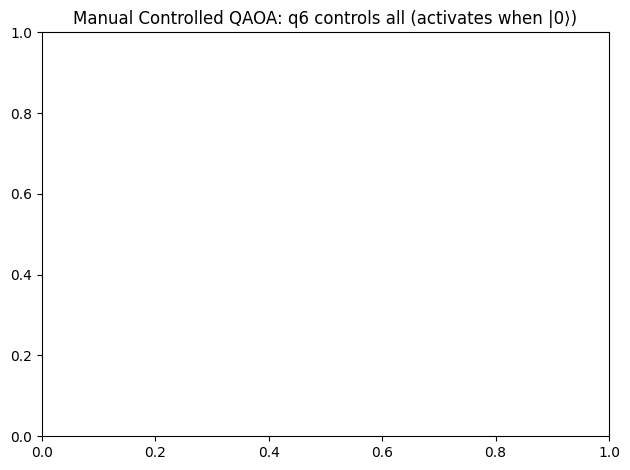

Text representation:
     ┌───┐ Initial |+⟩ ┌───────────────┐                                   »
q_0: ┤ H ├──────░──────┤ Rz(14.0*γ[0]) ├──■────────────────────────────────»
     ├───┤      ░      ├───────────────┤  │                                »
q_1: ┤ H ├──────░──────┤ Rz(28.0*γ[0]) ├──┼────────────────■───────────────»
     ├───┤      ░      ├───────────────┤  │ZZ(234.0*γ[0])  │               »
q_2: ┤ H ├──────░──────┤ Rz(42.0*γ[0]) ├──■────────────────┼───────────────»
     ├───┤      ░      ├───────────────┴┐                  │               »
q_3: ┤ H ├──────░──────┤ Rz(-16.0*γ[0]) ├──────────────────┼───────────────»
     ├───┤      ░      ├────────────────┤                  │               »
q_4: ┤ H ├──────░──────┤ Rz(-32.0*γ[0]) ├──────────────────┼───────────────»
     ├───┤      ░      ├────────────────┤                  │               »
q_5: ┤ H ├──────░──────┤ Rz(-48.0*γ[0]) ├──────────────────┼───────────────»
     ├───┤      ░      ├───────────────┬┘              

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def create_controlled_mixer(num_qubits, control_qubit=0):
    """
    Create controlled mixer where control_qubit controls RX on all others
    RX happens when control qubit is |0⟩
    """
    pauli_terms = []
    
    # For each target qubit (all except the control)
    for target_idx in range(num_qubits):
        if target_idx == control_qubit:
            continue  # Skip the control qubit itself
            
        # X_target term (from (I + Z)/2 * X = (X + ZX)/2)
        x_term = ["I"] * num_qubits
        x_term[target_idx] = "X"
        x_string = "".join(x_term)
        pauli_terms.append((x_string, 0.5))
        
        # Z_control * X_target term (positive for control=|0⟩)
        zx_term = ["I"] * num_qubits
        zx_term[control_qubit] = "Z"  # Z on control qubit
        zx_term[target_idx] = "X"     # X on target
        zx_string = "".join(zx_term)
        pauli_terms.append((zx_string, 0.5))  # Positive for control=|0⟩
    
    return SparsePauliOp.from_list(pauli_terms)

def create_manual_controlled_qaoa_ansatz(cost_operator, control_qubit=6, reps=1):
    """
    Create manual controlled QAOA ansatz that works with optimization
    Uses the bit-flip trick: X-control-X for control=|0⟩
    """
    num_qubits = cost_operator.num_qubits
    qc = QuantumCircuit(num_qubits)
    
    # Create parameter arrays
    gamma_params = [Parameter(f'γ[{i}]') for i in range(reps)]
    beta_params = [Parameter(f'β[{i}]') for i in range(reps)]
    
    print(f"Creating manual controlled QAOA ansatz:")
    print(f"  - Control qubit: q{control_qubit} (activates when |0⟩)")
    print(f"  - Target qubits: {[i for i in range(num_qubits) if i != control_qubit]}")
    print(f"  - QAOA layers: {reps}")
    
    # 1. Initialize all qubits in superposition
    qc.h(range(num_qubits))
    qc.barrier(label='Initial |+⟩')
    
    for rep in range(reps):
        # 2. Cost layer - apply the actual Hamiltonian evolution
        # We'll approximate this with the key terms from your ising_op
        
        # Single qubit terms (RZ gates)
        cost_coeffs = []
        for i, (pauli_str, coeff) in enumerate(zip(cost_operator.paulis, cost_operator.coeffs)):
            pauli_str = str(pauli_str)
            # Count non-identity terms
            non_identity_count = sum(1 for p in pauli_str if p != 'I')
            
            if non_identity_count == 1:  # Single qubit term
                qubit_idx = pauli_str.index('Z')
                qc.rz(2 * gamma_params[rep] * coeff.real, qubit_idx)
            elif non_identity_count == 2:  # Two qubit term
                z_positions = [i for i, p in enumerate(pauli_str) if p == 'Z']
                if len(z_positions) == 2:
                    qc.rzz(2 * gamma_params[rep] * coeff.real, z_positions[0], z_positions[1])
        
        qc.barrier(label=f'Cost {rep+1}')
        
        # 3. Controlled Mixer layer - the key innovation!
        # Use bit-flip trick: X-control-X makes control activate when |0⟩
        
        qc.x(control_qubit)  # Flip control qubit
        qc.barrier(label='Flip Control')
        
        # Apply controlled-RX gates (now activate when original state was |0⟩)
        for target in range(num_qubits):
            if target != control_qubit:
                qc.crx(2 * beta_params[rep], control_qubit, target)
        
        qc.barrier(label='Controlled RX')
        qc.x(control_qubit)  # Flip control qubit back
        qc.barrier(label='Flip Back')
    
    print(f"Manual ansatz created with {len(qc.parameters)} parameters")
    return qc

def create_qaoa_circuit(cost_operator, reps=1, use_controlled_mixer=False, control_qubit=0, use_manual=False):
    """
    MODIFIED: Added manual controlled circuit option
    """
    
    if use_manual and use_controlled_mixer:
        print(f"Using MANUAL controlled mixer: q{control_qubit} controls all other qubits (activates when q{control_qubit}=|0⟩)")
        return create_manual_controlled_qaoa_ansatz(cost_operator, control_qubit, reps)
    
    elif use_controlled_mixer:
        # Use QAOAAnsatz with custom mixer (the messy decomposition version)
        mixer_op = create_controlled_mixer(cost_operator.num_qubits, control_qubit)
        print(f"Using QAOAAnsatz controlled mixer: q{control_qubit} controls all other qubits (activates when q{control_qubit}=|0⟩)")
        qaoa_custom = QAOAAnsatz(cost_operator=cost_operator, mixer_operator=mixer_op, reps=reps, flatten=True)
        qaoa_custom.draw('mpl')
        plt.show()
        return qaoa_custom
    else:
        print("Using standard QAOA mixer")
        return QAOAAnsatz(
            cost_operator=cost_operator,
            reps=reps,
            flatten=True
        )

def create_sampling_circuit(qaoa_ansatz, parameters):
    """Create circuit with measurements for final sampling"""
    bound_circuit = qaoa_ansatz.assign_parameters(parameters)
    bound_circuit.measure_all()
    return bound_circuit

def objective_function_fixed(parameters, qaoa_ansatz, cost_operator):
    """Fixed objective function using StatevectorEstimator"""
    estimator = StatevectorEstimator()
    
    # Handle layout for hardware compatibility
    if hasattr(qaoa_ansatz, 'layout') and qaoa_ansatz.layout is not None:
        isa_hamiltonian = cost_operator.apply_layout(qaoa_ansatz.layout)
    else:
        isa_hamiltonian = cost_operator
    
    # Use the pub format
    pub = (qaoa_ansatz, isa_hamiltonian, parameters)
    job = estimator.run([pub])
    results = job.result()[0]
    
    return float(results.data.evs)

def run_qaoa_optimization(cost_operator, reps=1, max_iterations=500, use_controlled_mixer=False, control_qubit=0, use_manual=False):
    """
    MODIFIED: Added manual controlled circuit option
    """
    
    # Create QAOA ansatz
    qaoa_ansatz = create_qaoa_circuit(cost_operator, reps=reps, 
                                    use_controlled_mixer=use_controlled_mixer, 
                                    control_qubit=control_qubit,
                                    use_manual=use_manual)
    
    print(f"QAOA circuit has {qaoa_ansatz.num_parameters} parameters")
    print(f"Circuit depth: {qaoa_ansatz.depth()}")
    print(f"Number of qubits: {qaoa_ansatz.num_qubits}")
    
    # Show circuit visualization for manual version
    if use_manual and use_controlled_mixer:
        print("Manual controlled circuit created! Drawing...")
        fig = qaoa_ansatz.draw('mpl', style='iqp')
        plt.title(f'Manual Controlled QAOA: q{control_qubit} controls all (activates when |0⟩)')
        plt.tight_layout()
        plt.show()
        
        # Also show text version
        print("Text representation:")
        print(qaoa_ansatz.draw())
    
    # Better parameter initialization for QAOA
    np.random.seed(69)
    initial_params = np.random.uniform(0, 0.5, qaoa_ansatz.num_parameters)
    print(f"Initial parameters: {initial_params}")
    
    # Test objective function
    print("Testing objective function...")
    initial_energy = objective_function_fixed(initial_params, qaoa_ansatz, cost_operator)
    print(f"Initial energy: {initial_energy:.3f}")
    
    # Run optimization with multiple methods if needed
    print("Starting optimization...")
    
    # Try COBYLA first (good for QAOA)
    result = minimize(
        objective_function_fixed,
        initial_params,
        args=(qaoa_ansatz, cost_operator),
        method='COBYLA',
        options={'maxiter': max_iterations, 'disp': True}
    )
    
    # If COBYLA didn't converge, try Powell
    if not result.success and result.nfev >= max_iterations * 0.8:
        print("\nCOBYLA hit max iterations, trying Powell method...")
        result = minimize(
            objective_function_fixed,
            result.x,  # Start from COBYLA result
            args=(qaoa_ansatz, cost_operator),
            method='Powell',
            options={'maxiter': max_iterations//2, 'disp': True}
        )
    
    print(f"\nOptimization completed!")
    print(f"Success: {result.success}")
    print(f"Optimal energy: {result.fun:.3f}")
    print(f"Energy improvement: {initial_energy - result.fun:.3f}")
    print(f"Message: {result.message}")
    
    return result, qaoa_ansatz

def sample_final_results(qaoa_ansatz, optimal_params, shots=1000):
    """Sample from the optimized quantum state"""
    
    # Create sampling circuit with measurements
    sampling_circuit = create_sampling_circuit(qaoa_ansatz, optimal_params)
    
    # Use StatevectorSampler for sampling
    sampler = StatevectorSampler()
    job = sampler.run([sampling_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    
    return counts

def evaluate_bitstring_cost(bitstring, cost_operator):
    """Evaluate the actual cost of a solution bitstring"""
    z_values = [1 if bit == '0' else -1 for bit in bitstring]
    
    cost = 0
    for pauli_string, coeff in zip(cost_operator.paulis, cost_operator.coeffs):
        term_value = 1
        for i, pauli in enumerate(str(pauli_string)):
            if pauli == 'Z':
                term_value *= z_values[i]
        cost += coeff.real * term_value
    
    return cost

def complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=False, control_qubit=0, use_manual=False):
    """
    MODIFIED: Added manual controlled circuit option
    Complete QAOA workflow with controlled mixer support
    """
    
    print(f"\n{'='*60}")
    print(f"QAOA WORKFLOW")
    print(f"{'='*60}")
    print(f"Configuration:")
    print(f"  - QAOA layers (reps): {reps}")
    print(f"  - Use controlled mixer: {use_controlled_mixer}")
    print(f"  - Use manual implementation: {use_manual}")
    if use_controlled_mixer:
        print(f"  - Control qubit: q{control_qubit} (x_control_0[0])")
        print(f"  - Control logic: RX rotations when q{control_qubit} = |0⟩")
    print()
    
    # Run optimization
    result, qaoa_ansatz = run_qaoa_optimization(ising_op, reps=reps, max_iterations=500,
                                              use_controlled_mixer=use_controlled_mixer,
                                              control_qubit=control_qubit,
                                              use_manual=use_manual)
    
    print(f"\nProceeding with sampling...")
    
    # Sample from optimized state
    print("Sampling from optimized state...")
    counts = sample_final_results(qaoa_ansatz, result.x, shots=1000)
    
    # Analyze top solutions
    print("\nTop 10 most frequent solutions:")
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for i, (bitstring, count) in enumerate(sorted_counts[:10]):
        probability = count / 1000
        actual_cost = evaluate_bitstring_cost(bitstring, ising_op)
        print(f"{i+1:2d}. {bitstring}: {count:3d} counts ({probability:.1%}), cost = {actual_cost:.1f}")
    
    # Find the best solution by actual cost
    print("\nBest solutions by actual cost:")
    cost_sorted = [(bs, cnt, evaluate_bitstring_cost(bs, ising_op)) 
                   for bs, cnt in sorted_counts]
    cost_sorted.sort(key=lambda x: x[2])  # Sort by cost
    
    for i, (bitstring, count, cost) in enumerate(cost_sorted[:30]):
        probability = count / 1000
        print(f"{i+1}. {bitstring}: cost = {cost:.1f}, frequency = {count} ({probability:.1%})")
    
    # Analysis of control qubit behavior (if using controlled mixer)
    if use_controlled_mixer:
        print(f"\n{'='*40}")
        print(f"CONTROL QUBIT ANALYSIS (q{control_qubit})")
        print(f"{'='*40}")
        
        control_0_solutions = []
        control_1_solutions = []
        
        for bitstring, count in sorted_counts:
            if bitstring[control_qubit] == '0':
                control_0_solutions.append((bitstring, count))
            else:
                control_1_solutions.append((bitstring, count))
        
        total_control_0 = sum(count for _, count in control_0_solutions)
        total_control_1 = sum(count for _, count in control_1_solutions)
        
        print(f"Solutions with q{control_qubit}=|0⟩ (control active): {total_control_0} ({total_control_0/10:.1f}%)")
        print(f"Solutions with q{control_qubit}=|1⟩ (control inactive): {total_control_1} ({total_control_1/10:.1f}%)")
        
        print(f"\nTop solutions when q{control_qubit}=|0⟩ (control active):")
        for i, (bitstring, count) in enumerate(control_0_solutions[:5]):
            cost = evaluate_bitstring_cost(bitstring, ising_op)
            print(f"  {bitstring}: cost = {cost:.1f}, frequency = {count}")
        
        print(f"\nTop solutions when q{control_qubit}=|1⟩ (control inactive):")  
        for i, (bitstring, count) in enumerate(control_1_solutions[:5]):
            cost = evaluate_bitstring_cost(bitstring, ising_op)
            print(f"  {bitstring}: cost = {cost:.1f}, frequency = {count}")
    
    return result, sorted_counts

# USAGE EXAMPLES WITH MANUAL CONTROLLED MIXER:
print("="*60)
print("ENHANCED QAOA IMPLEMENTATION")
print("="*60)
print("Usage examples:")
print("1. Standard QAOA:")
print("   result, solutions = complete_qaoa_workflow(ising_op, reps=1)")
print()
print("2. Controlled mixer (QAOAAnsatz - messy decomposition):")
print("   result, solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=6)")
print()
print("3. ⭐ MANUAL controlled mixer (clean circuit - RECOMMENDED):")
print("   result, solutions = complete_qaoa_workflow(ising_op, reps=1, use_controlled_mixer=True, control_qubit=6, use_manual=True)")
print()

# Run the controlled mixer version with your x_control_0[0] variable
print("Running controlled QAOA where x_control_0[0] (q6) controls all other variables...")
optimization_result, top_solutions = complete_qaoa_workflow(
    ising_op, 
    reps=5, 
    use_controlled_mixer=True, 
    control_qubit=6,  # x_control_0[0] is qubit 6
    use_manual=True   # Use clean manual implementation
)